In [433]:
import pandas as pd
import re
import numpy as np
import time
from datetime import date
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import plotly.express as px
import nltk


In [434]:
tweets = pd.read_csv('Tweet.csv')
company_tweet = pd.read_csv('Company_Tweet.csv')
result = pd.read_csv('result.csv')
stock = pd.read_csv('CompanyValues.csv')
train_df = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding="ISO-8859-1",names=['target','ids','date','flag','user','text'])
reaction = pd.read_csv('reaction.csv')

TRAINING- SENTIMENT ANALYSIS

In [451]:
nltk.download('stopwords')


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


False

In [469]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 
             're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [470]:
STOPWORDS = set(stopwordlist)
def stopword_remover(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
# data['text'] = data['text'].apply(lambda text: stopword_remover(text))
# data['text'].head()

In [471]:
import string
eng_punct = string.punctuation
punct_list = eng_punct
def clean_punct(text):
    translator = str.maketrans('', '', punct_list)
    return text.translate(translator)
# data['text']= data['text'].apply(lambda x: clean_punct(x))
# data['text'].head()

In [458]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)
# data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
# data['text'].tail()

19995    Not much time off this weekend work trip to Ma...
19996                            One more day of holidays 
19997    feeling so down right now  i hate you DAMN HUM...
19998    geezi hv to READ the whole book of personality...
19999    I threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [459]:
def cleaning_URLs(datas):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',datas)
# data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
# data['text'].tail()

19995    Not much time off this weekend work trip to Ma...
19996                            One more day of holidays 
19997    feeling so down right now  i hate you DAMN HUM...
19998    geezi hv to READ the whole book of personality...
19999    I threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [460]:
def cleaning_numbers(datas):
    return re.sub('[0-9]+', '', datas)
# data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
# data['text'].tail()

19995    Not much time off this weekend work trip to Ma...
19996                            One more day of holidays 
19997    feeling so down right now  i hate you DAMN HUM...
19998    geezi hv to READ the whole book of personality...
19999    I threw my sign at donnie and he bent over to ...
Name: text, dtype: object

Visulation of Targets

TWEETS

In [150]:
tweets.head()


,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


In [151]:
tweets.tail()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
3717959,1212159765914079234,TEEELAZER,1577836383,That $SPY $SPX puuump in the last hour was the...,1,0,6
3717960,1212159838882533376,ShortingIsFun,1577836401,In 2020 I may start Tweeting out positive news...,0,0,1
3717961,1212160015332728833,Commuternyc,1577836443,Patiently Waiting for the no twitter sitter tw...,0,0,5
3717962,1212160410692046849,MoriaCrypto,1577836537,I don't discriminate. I own both $aapl and $ms...,1,0,1
3717963,1212160477159206912,treabase,1577836553,"$AAPL #patent 10,522,475 Vertical interconnect...",0,0,0


In [152]:
print(tweets.shape)

(3717964, 7)


In [153]:
tweets.info()
print(tweets.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3717964 entries, 0 to 3717963
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   tweet_id     int64 
 1   writer       object
 2   post_date    int64 
 3   body         object
 4   comment_num  int64 
 5   retweet_num  int64 
 6   like_num     int64 
dtypes: int64(5), object(2)
memory usage: 198.6+ MB
           tweet_id     post_date   comment_num   retweet_num      like_num
count  3.717964e+06  3.717964e+06  3.717964e+06  3.717964e+06  3.717964e+06
mean   8.797444e+17  1.498582e+09  3.123642e-01  6.214807e-01  2.219982e+00
std    1.924039e+17  4.587266e+07  1.966064e+00  7.009571e+00  1.429093e+01
min    5.504415e+17  1.420070e+09  0.000000e+00  0.000000e+00  0.000000e+00
25%    7.169886e+17  1.459778e+09  0.000000e+00  0.000000e+00  0.000000e+00
50%    8.743180e+17  1.497289e+09  0.000000e+00  0.000000e+00  0.000000e+00
75%    1.050771e+18  1.539358e+09  0.000000e+00  0.000000e+00  1.000000e+00
max

COMPANIES

In [154]:
companies = result['ticker_symbol'].unique()
print(companies)
company_df = pd.DataFrame({'company': companies})

['AAPL' 'AMZN' 'TSLA' 'MSFT' 'GOOG' 'GOOGL']


In [155]:
company_df.head()

,company
0,AAPL
1,AMZN
2,TSLA
3,MSFT
4,GOOG


RESULT

In [156]:
result.head()

,Unnamed: 0,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,reaction
0,0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,Neutral
1,1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,Negative
2,2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,Negative
3,3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,Neutral
4,4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,Neutral


In [157]:
result.tail()

,Unnamed: 0,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,reaction
4336440,4336440,1212159838882533376,ShortingIsFun,1577836401,In 2020 I may start Tweeting out positive news...,0,0,1,TSLA,Negative
4336441,4336441,1212160015332728833,Commuternyc,1577836443,Patiently Waiting for the no twitter sitter tw...,0,0,5,TSLA,Negative
4336442,4336442,1212160410692046849,MoriaCrypto,1577836537,I don't discriminate. I own both $aapl and $ms...,1,0,1,AAPL,Neutral
4336443,4336443,1212160410692046849,MoriaCrypto,1577836537,I don't discriminate. I own both $aapl and $ms...,1,0,1,MSFT,Neutral
4336444,4336444,1212160477159206912,treabase,1577836553,"$AAPL #patent 10,522,475 Vertical interconnect...",0,0,0,AAPL,Neutral


In [158]:
print(result.shape)

(4336445, 10)


In [159]:
result.describe()

,Unnamed: 0,tweet_id,post_date,comment_num,retweet_num,like_num
count,4.336445e+06,4.336445e+06,4.336445e+06,4.336445e+06,4.336445e+06,4.336445e+06
mean,2.168222e+06,8.834282e+17,1.499461e+09,2.923863e-01,6.347647e-01,2.103625e+00
std,1.251824e+06,1.927735e+17,4.596080e+07,1.885788e+00,6.986371e+00,1.371744e+01
min,0.000000e+00,5.504415e+17,1.420070e+09,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.084111e+06,7.185450e+17,1.460149e+09,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.168222e+06,8.825934e+17,1.499262e+09,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.252333e+06,1.054776e+18,1.540313e+09,0.000000e+00,0.000000e+00,1.000000e+00
max,4.336444e+06,1.212160e+18,1.577837e+09,6.310000e+02,9.990000e+02,9.990000e+02


In [160]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336445 entries, 0 to 4336444
Data columns (total 10 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   Unnamed: 0     int64 
 1   tweet_id       int64 
 2   writer         object
 3   post_date      int64 
 4   body           object
 5   comment_num    int64 
 6   retweet_num    int64 
 7   like_num       int64 
 8   ticker_symbol  object
 9   reaction       object
dtypes: int64(6), object(4)
memory usage: 330.8+ MB


In [161]:
result = result.replace('Negative', -1)
result = result.replace('Neutral', 0)
result = result.replace('Positive', 1)

In [429]:
result.head(10)

,tweet_id,body,comment_num,retweet_num,like_num,ticker_symbol,reaction,date
0,550441509175443456,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,0,2015-01-01
1,550441672312512512,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,-1,2015-01-01
2,550441732014223360,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,-1,2015-01-01
3,550442977802207232,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,0,2015-01-01
4,550443807834402816,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,0,2015-01-01
5,550443807834402816,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,TSLA,0,2015-01-01
6,550443808606126081,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,0,2015-01-01
7,550443808606126081,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,TSLA,0,2015-01-01
8,550443809700851716,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,0,2015-01-01
9,550443809700851716,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,TSLA,0,2015-01-01


In [163]:
dates = []
def toDate(num):
    temp = datetime.fromtimestamp(int(num))
    dates.append(temp)


In [164]:
for date in result['post_date']:
    toDate(date)

In [165]:
result['date'] = dates

In [166]:
result['date'] = pd.to_datetime(result['date']).dt.date

In [167]:
result.head()

,Unnamed: 0,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,reaction,date
0,0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,0,2015-01-01
1,1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,-1,2015-01-01
2,2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,-1,2015-01-01
3,3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,0,2015-01-01
4,4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,0,2015-01-01


In [168]:
result = result.drop(['Unnamed: 0'], axis=1)

In [169]:
result = result.drop(['post_date'], axis=1)

In [170]:
result.head()

,tweet_id,writer,body,comment_num,retweet_num,like_num,ticker_symbol,reaction,date
0,550441509175443456,VisualStockRSRC,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,0,2015-01-01
1,550441672312512512,KeralaGuy77,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,-1,2015-01-01
2,550441732014223360,DozenStocks,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,-1,2015-01-01
3,550442977802207232,ShowDreamCar,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,0,2015-01-01
4,550443807834402816,i_Know_First,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,0,2015-01-01


In [171]:
result.isnull().values.any()


True

In [172]:
result.isnull().sum().sum()

55919

[Text(0.5, 1.0, 'Missing Data')]

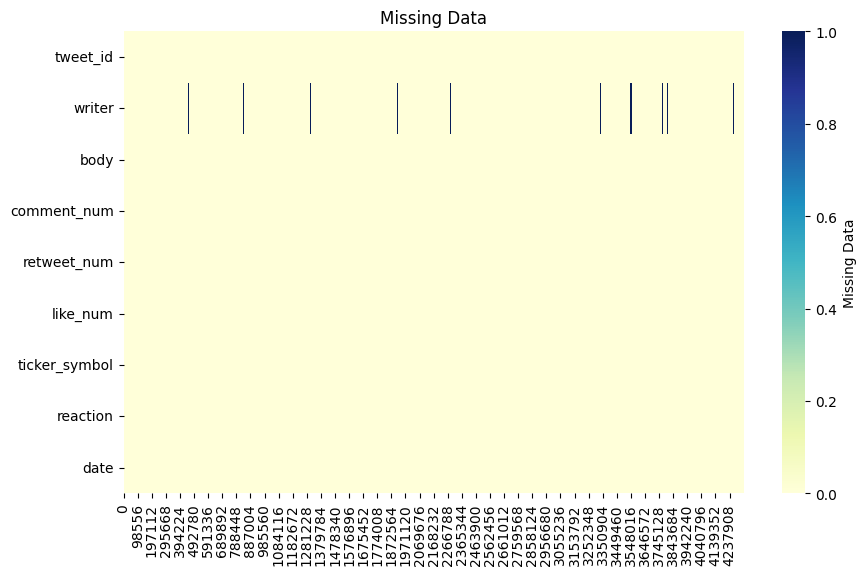

In [173]:
plt.figure(figsize=(10,6))
sns.heatmap(result.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'}).set(title="Missing Data")

In [174]:
result['writer'] = result['writer'].fillna("Unknown Author")

In [175]:
result['writer'].isnull().values.any()

False

[Text(0.5, 1.0, 'Missing Data')]

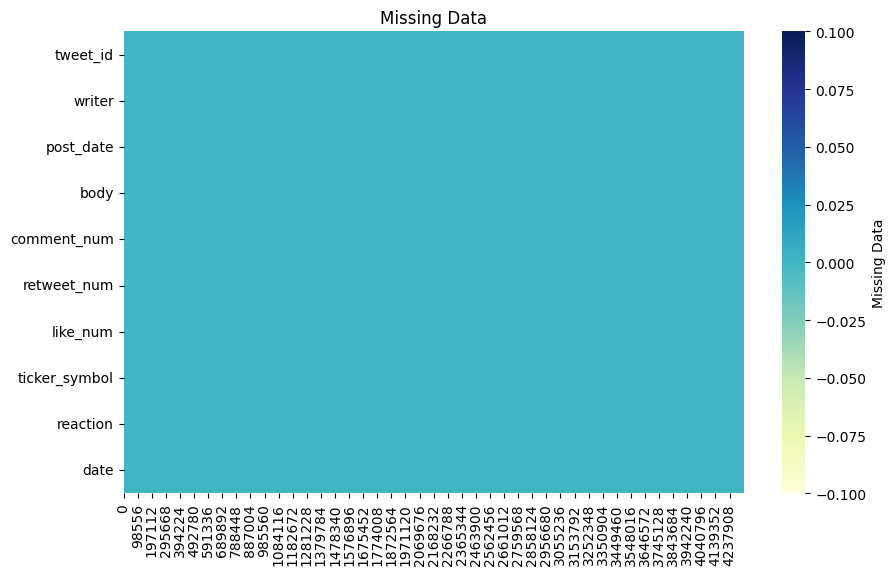

In [51]:
plt.figure(figsize=(10,6))
sns.heatmap(result.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'}).set(title='Missing Data')

NUMBER OF TWEETS RELATING TO EACH COMPANY

In [176]:
num_tweets_company = result.groupby(result['ticker_symbol'].tolist(), as_index=False).size()

In [177]:
num_tweets_company.head()

,index,size
0,AAPL,1425013
1,AMZN,718715
2,GOOG,392569
3,GOOGL,327569
4,MSFT,375711


Text(0.5, 1.0, 'Number of tweets releated to companies')

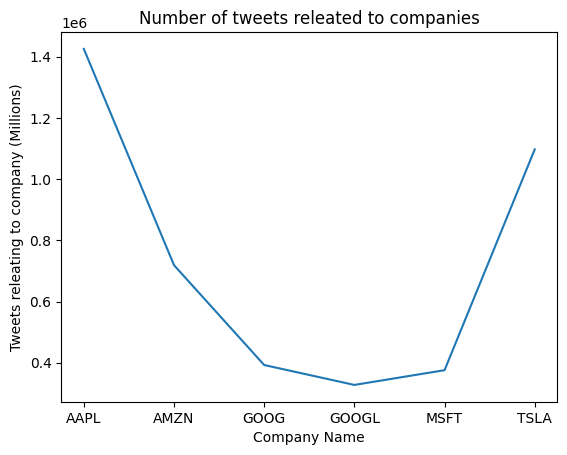

In [178]:
plt.plot( num_tweets_company['index'], num_tweets_company['size'])
plt.ylabel('Tweets releating to company (Millions)')
plt.xlabel('Company Name')
plt.title('Number of tweets releated to companies')

In [179]:
company_tweet_likes = []
company_tweet_retweet = []
for name in companies:
    
    company_tweet_likes.append(result.loc[result['ticker_symbol'] == name, 'like_num'].sum())
    company_tweet_retweet.append(result.loc[result['ticker_symbol'] == name, 'retweet_num'].sum())
print('Likes per company',company_tweet_likes)
print('Retweets per company',company_tweet_retweet)

Likes per company [1378670, 984166, 5769051, 347520, 235928, 406917]
Retweets per company [722396, 419783, 1078386, 193364, 147143, 191550]


Text(0, 0.5, 'Number of likes (Millions)')

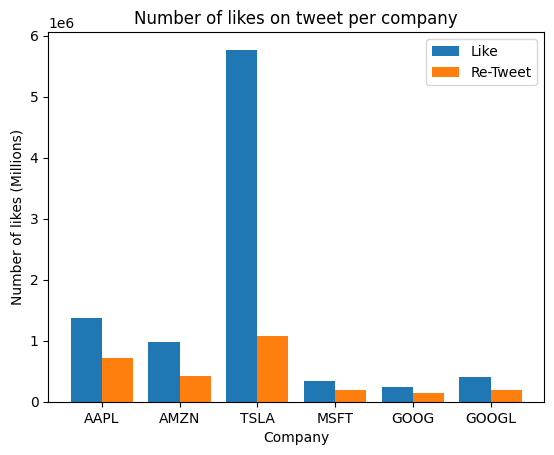

In [180]:
X_axis = np.arange(len(companies))
plt.bar(X_axis-0.2 ,company_tweet_likes,0.4, label = 'Like')
plt.bar(X_axis+0.2 ,company_tweet_retweet,0.4, label = 'Re-Tweet')

def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i,y_list[i-1],y_list[i-1])


plt.xticks(X_axis, companies)
plt.legend()
plt.title('Number of likes on tweet per company')
plt.xlabel('Company')

plt.ylabel('Number of likes (Millions)')

In [181]:
result = result.drop('writer', axis=1)


In [182]:
result.head()

,tweet_id,body,comment_num,retweet_num,like_num,ticker_symbol,reaction,date
0,550441509175443456,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,0,2015-01-01
1,550441672312512512,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,-1,2015-01-01
2,550441732014223360,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,-1,2015-01-01
3,550442977802207232,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,0,2015-01-01
4,550443807834402816,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,0,2015-01-01


In [183]:
result.tail()

,tweet_id,body,comment_num,retweet_num,like_num,ticker_symbol,reaction,date
4336440,1212159838882533376,In 2020 I may start Tweeting out positive news...,0,0,1,TSLA,-1,2019-12-31
4336441,1212160015332728833,Patiently Waiting for the no twitter sitter tw...,0,0,5,TSLA,-1,2019-12-31
4336442,1212160410692046849,I don't discriminate. I own both $aapl and $ms...,1,0,1,AAPL,0,2019-12-31
4336443,1212160410692046849,I don't discriminate. I own both $aapl and $ms...,1,0,1,MSFT,0,2019-12-31
4336444,1212160477159206912,"$AAPL #patent 10,522,475 Vertical interconnect...",0,0,0,AAPL,0,2019-12-31


In [184]:
df = (result.loc[(result['date'] >= datetime(2018, 1, 1).date()) & (result['date'] <= datetime(2020, 1, 1).date())])
df.tail()
df_reduce = df
df_reduce = df_reduce.drop('tweet_id', axis=1)
df_reduce = df_reduce.drop('comment_num', axis=1)
df_reduce = df_reduce.drop('retweet_num', axis=1)
df_reduce = df_reduce.drop('like_num', axis=1)

In [185]:
df_reduce = df_reduce.loc[df_reduce['ticker_symbol'] == 'AMZN']

In [187]:
df_reduce.tail(20)

,body,ticker_symbol,reaction,date
4336297,Global Market View 12/31/2019What an amazing y...,AMZN,1,2019-12-31
4336308,$INPX Exploding in after hours #IoT tech bein...,AMZN,0,2019-12-31
4336316,http://BlackboxStocks.US The World #1 Algorith...,AMZN,1,2019-12-31
4336322,$AMZN $WMT #Reliance’s #ecommerce venture JioM...,AMZN,0,2019-12-31
4336327,$tsla bears punching the air rn $es $spx $nq ...,AMZN,0,2019-12-31
4336342,U.S. holiday returns surge with booming e-comm...,AMZN,1,2019-12-31
4336344,New Years Resolution: Buy $AMZN. Far different...,AMZN,0,2019-12-31
4336347,This is the real competition to $amzn in India...,AMZN,1,2019-12-31
4336366,Number of leading stocks today: 55 $SPY $QQQ $...,AMZN,1,2019-12-31
4336375,The #Pursuit Of '#Happyness' - #Nasdaq Just Mo...,AMZN,0,2019-12-31


In [375]:
body_len = df_reduce['body'].str.split().str.len()
body_len.describe()

count    307180.000000
mean         22.461153
std          12.523114
min           1.000000
25%          13.000000
50%          20.000000
75%          31.000000
max          63.000000
Name: body, dtype: float64

<Axes: >

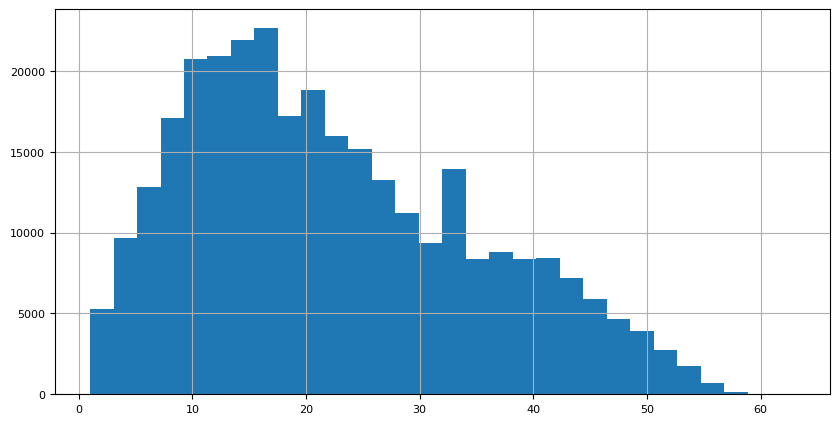

In [376]:
body_len.hist(figsize=(10, 5), bins=30, xlabelsize=8, ylabelsize=8)

In [188]:
df_reduce = df_reduce.reset_index(drop=True)
df_reduce.to_csv('data.csv', index=False)

In [189]:
df_reduce.shape

(307180, 4)

In [190]:
unique_days = df_reduce['date'].unique()
print(len(unique_days))

730


In [191]:
data = {'date': [0],'AMZN': 0 }
df_sum= pd.DataFrame(data)
df_sum.head()


,date,AMZN
0,0,0


In [192]:
days = df_reduce['date'].unique()
print(date)
for date in days:
    
    AMZN = ((result.loc[(result['ticker_symbol'] == 'AMZN' )& (result['date'] == date), 'reaction'].sum())/ (len(result.loc[(result['ticker_symbol'] == 'AMZN' )& (result['date'] == date)])))
    data = {'date': [date],'AMZN': AMZN }
    df_sum = df_sum.append(data, ignore_index=True)

1577836553


/var/folders/f0/zf6fxcgs5t778nd1ml7j0xlr0000gn/T/ipykernel_1361/279423811.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sum = df_sum.append(data, ignore_index=True)
/var/folders/f0/zf6fxcgs5t778nd1ml7j0xlr0000gn/T/ipykernel_1361/279423811.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sum = df_sum.append(data, ignore_index=True)
/var/folders/f0/zf6fxcgs5t778nd1ml7j0xlr0000gn/T/ipykernel_1361/279423811.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sum = df_sum.append(data, ignore_index=True)
/var/folders/f0/zf6fxcgs5t778nd1ml7j0xlr0000gn/T/ipykernel_1361/279423811.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

In [194]:
df_sum = df_sum.drop(0)



In [195]:
df_sum = df_sum.reset_index(drop=True)

In [198]:
df_sum.head()

,date,AMZN
0,[2018-01-01],0.522059
1,[2018-01-02],0.428862
2,[2018-01-03],0.335366
3,[2018-01-04],0.397436
4,[2018-01-05],0.395387


In [45]:
# df.to_csv('reaction.csv', index=False)

In [199]:
reaction.head()

,date,AAPL,AMZN,TSLA,MSFT,GOOG,GOOGL
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"[datetime.date(2015, 1, 1)]",0.257525,-0.145038,0.171717,0.277778,0.383333,0.444444
2,"[datetime.date(2015, 1, 2)]",0.163783,0.241379,0.268657,0.317757,0.344828,0.288288
3,"[datetime.date(2015, 1, 3)]",0.416185,0.298507,0.145833,0.271186,0.658228,0.807143
4,"[datetime.date(2015, 1, 4)]",0.389163,0.223529,0.210526,0.411765,0.495283,0.857143


In [200]:
reaction = reaction.drop(0)

In [201]:
reaction.head()

,date,AAPL,AMZN,TSLA,MSFT,GOOG,GOOGL
1,"[datetime.date(2015, 1, 1)]",0.257525,-0.145038,0.171717,0.277778,0.383333,0.444444
2,"[datetime.date(2015, 1, 2)]",0.163783,0.241379,0.268657,0.317757,0.344828,0.288288
3,"[datetime.date(2015, 1, 3)]",0.416185,0.298507,0.145833,0.271186,0.658228,0.807143
4,"[datetime.date(2015, 1, 4)]",0.389163,0.223529,0.210526,0.411765,0.495283,0.857143
5,"[datetime.date(2015, 1, 5)]",0.223191,0.323843,0.287770,0.151786,0.404682,0.610390


In [202]:
reaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 1 to 1826
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1826 non-null   object 
 1   AAPL    1823 non-null   float64
 2   AMZN    1826 non-null   float64
 3   TSLA    1826 non-null   float64
 4   MSFT    1826 non-null   float64
 5   GOOG    1825 non-null   float64
 6   GOOGL   1826 non-null   float64
dtypes: float64(6), object(1)
memory usage: 100.0+ KB


In [399]:
stocks = pd.read_csv('stocks.csv')

In [400]:
stocks.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AMZN,2010-06-01,123.2400,3650661,124.9700,126.5720,123.0200
1,AAPL,2010-06-01,37.2614,218455576,37.0986,37.9914,36.9943
2,GOOGL,2010-06-01,243.6667,2664303,242.6868,248.0565,242.5302
3,MSFT,2010-06-01,25.8900,76120800,25.5300,26.3100,25.5200
4,GOOGL,2010-06-02,249.2233,2513109,245.8439,249.4759,243.2071


[Text(0.5, 1.0, 'Missing Data')]

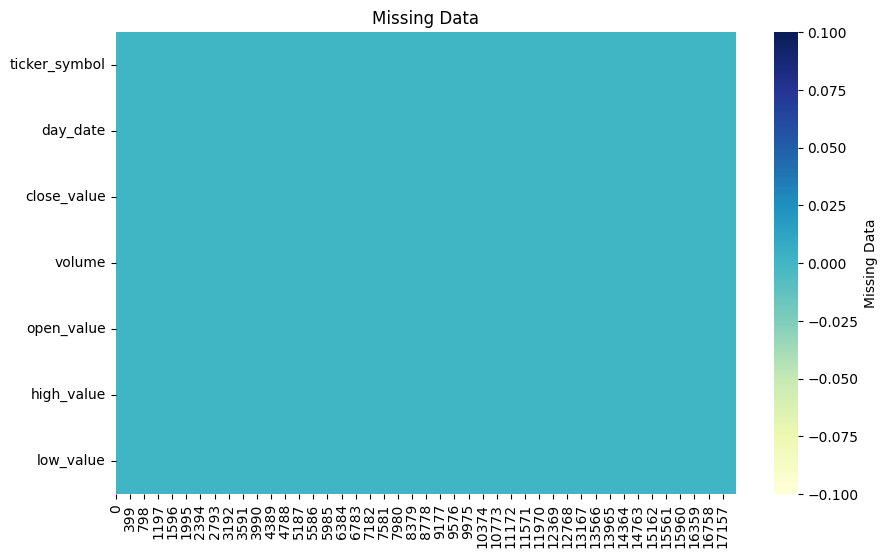

In [343]:
plt.figure(figsize=(10,6))
sns.heatmap(stocks.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'}).set(title='Missing Data')

In [401]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17528 entries, 0 to 17527
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ticker_symbol  17528 non-null  object 
 1   day_date       17528 non-null  object 
 2   close_value    17528 non-null  float64
 3   volume         17528 non-null  int64  
 4   open_value     17528 non-null  float64
 5   high_value     17528 non-null  float64
 6   low_value      17528 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 958.7+ KB


In [402]:
print(stocks.shape)

(17528, 7)


In [403]:
stocks.describe()

,close_value,volume,open_value,high_value,low_value
count,17528.000000,1.752800e+04,17528.000000,17528.000000,17528.000000
mean,455.167040,2.025441e+07,455.314451,459.710597,450.466694
std,469.324583,3.322733e+07,469.588291,473.771691,464.794791
min,15.800000,7.932000e+03,16.140000,16.630000,14.980000
25%,100.300000,2.075086e+06,99.883750,100.927500,98.940000
50%,256.500000,4.835618e+06,256.095000,259.604500,252.177400
75%,735.630000,2.704358e+07,735.740000,742.000000,728.920025
max,2497.940000,4.624423e+08,2500.000000,2525.450000,2467.270000


In [404]:
stocks = stocks.loc[5954:]

In [405]:
stocks.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
5954,MSFT,2015-01-01,46.45,21551090,46.73,47.44,46.45
5955,AAPL,2015-01-01,110.38,41304780,112.82,113.13,110.21
5956,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.25
5957,GOOG,2015-01-01,526.40,1367110,531.25,532.60,525.80
5958,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.01


In [406]:
stocks = stocks.reset_index(drop=True)

In [407]:
stocks.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,MSFT,2015-01-01,46.45,21551090,46.73,47.44,46.45
1,AAPL,2015-01-01,110.38,41304780,112.82,113.13,110.21
2,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.25
3,GOOG,2015-01-01,526.40,1367110,531.25,532.60,525.80
4,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.01


In [408]:
stocks.shape

(11574, 7)

In [409]:
stocks = stocks.loc[stocks['ticker_symbol'] == 'AMZN']

stocks = stocks.reset_index(drop=True)

In [410]:
stocks.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.0100
1,AMZN,2015-01-02,308.52,2785167,312.58,314.75,306.9601
2,AMZN,2015-01-03,308.52,2785167,312.58,314.75,306.9601
3,AMZN,2015-01-04,308.52,2785167,312.58,314.75,306.9601
4,AMZN,2015-01-05,302.19,2768215,307.01,308.38,300.8500


/var/folders/f0/zf6fxcgs5t778nd1ml7j0xlr0000gn/T/ipykernel_1361/2887538280.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i+1)


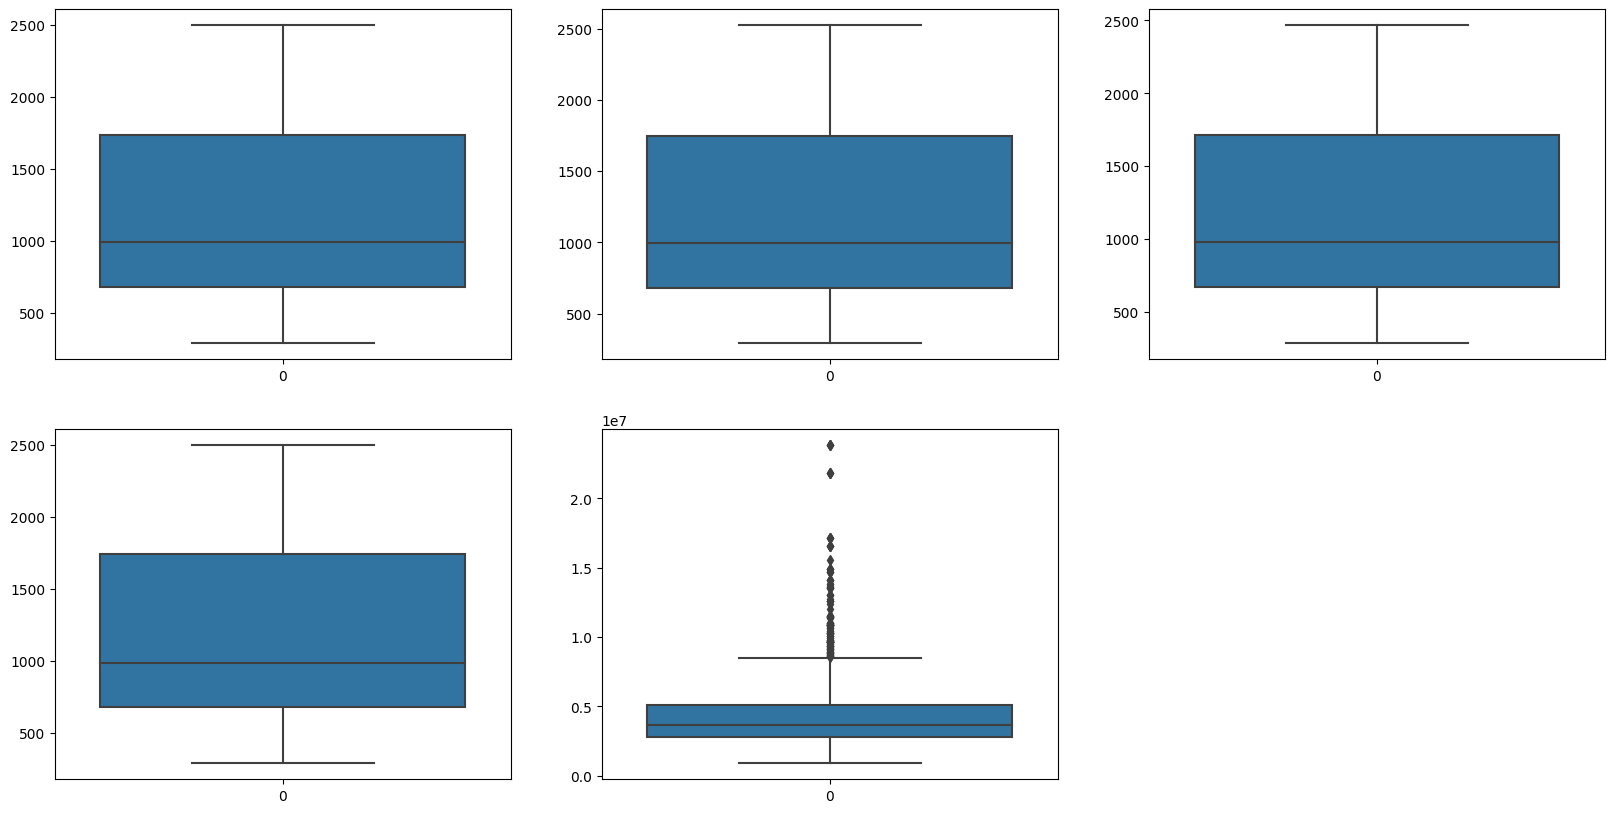

In [354]:
features = ['open_value', 'high_value', 'low_value', 'close_value', 'volume']
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sns.boxplot(stocks[col])
plt.show()

In [398]:
vals = stocks['open_value', 'close_value']
print(vals)

KeyError: ('open_value', 'close_value')

In [415]:
stocks1 = stocks
stocks1 = stocks1.drop('day_date', axis=1)


In [417]:
stocks1 = stocks1.drop('ticker_symbol', axis = 1)

In [418]:
stocks1.head()

,close_value,volume,open_value,high_value,low_value
0,310.35,2048676,311.55,312.98,310.0100
1,308.52,2785167,312.58,314.75,306.9601
2,308.52,2785167,312.58,314.75,306.9601
3,308.52,2785167,312.58,314.75,306.9601
4,302.19,2768215,307.01,308.38,300.8500


/var/folders/f0/zf6fxcgs5t778nd1ml7j0xlr0000gn/T/ipykernel_1361/3528010614.py:4: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



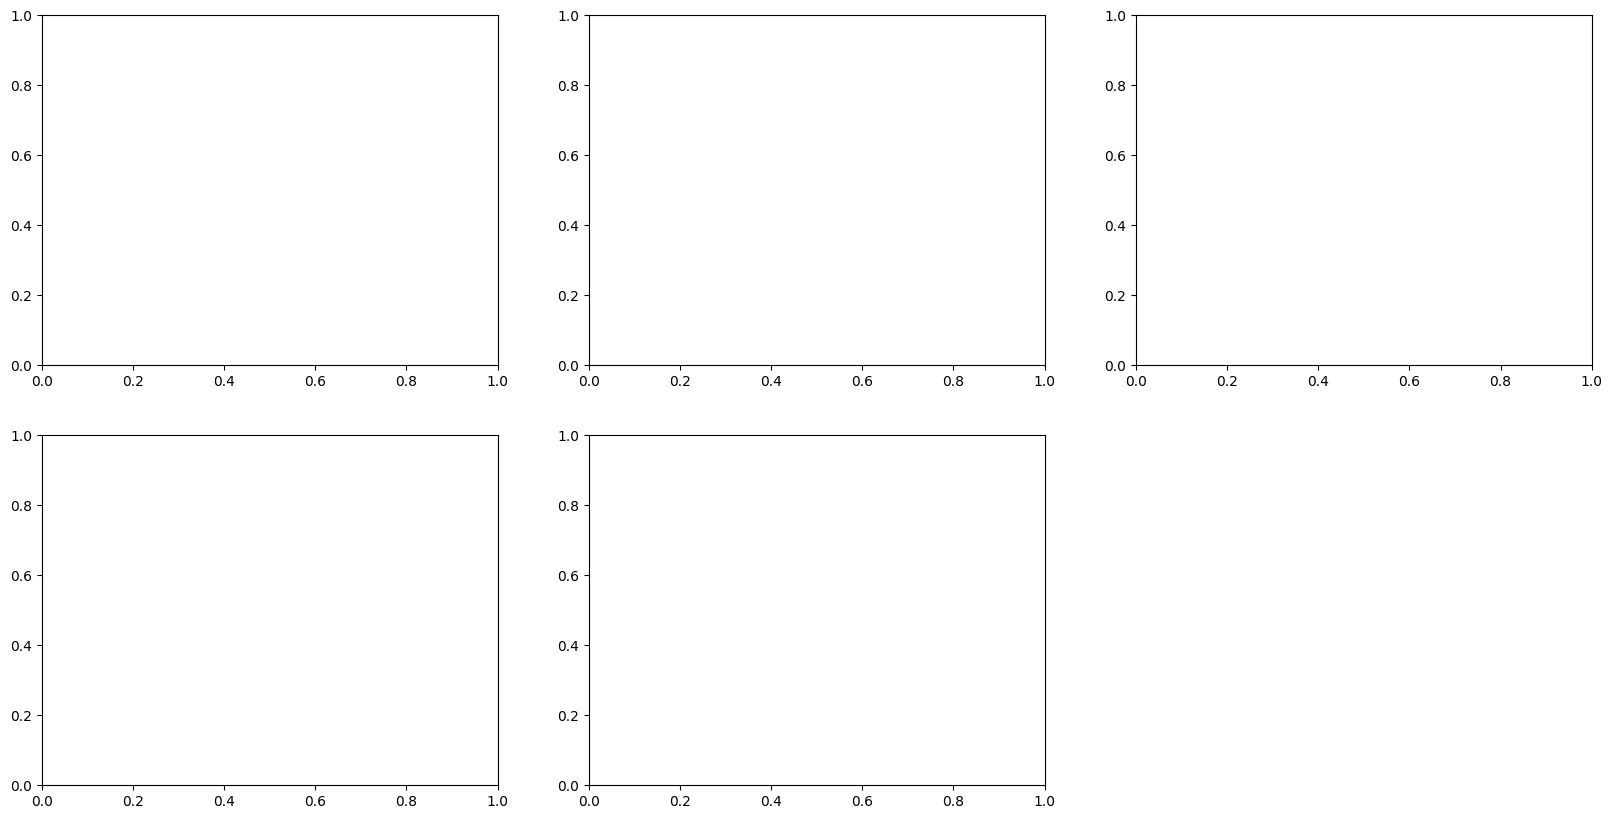

In [419]:
features = ['open_value', 'high_value', 'low_value', 'close_value', 'volume']
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  px.box(stocks[col])
plt.show()

In [421]:
stocks1 = stocks1.drop('volume', axis = 1)
fig = px.box(stocks1)
fig.show()

In [ ]:

fig = px.box(stocks1)
fig.show()

In [355]:
stocks.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.0100
1,AMZN,2015-01-02,308.52,2785167,312.58,314.75,306.9601
2,AMZN,2015-01-03,308.52,2785167,312.58,314.75,306.9601
3,AMZN,2015-01-04,308.52,2785167,312.58,314.75,306.9601
4,AMZN,2015-01-05,302.19,2768215,307.01,308.38,300.8500


In [356]:
# stocks = (stocks.loc[(stocks['day_date'] >= datetime(2018, 1, 1)) & (stocks['day_date'] <= datetime(2019, 1, 1))])
stocks.loc[1096]
# 1096

ticker_symbol          AMZN
day_date         2018-01-01
close_value         1169.47
volume              2678122
open_value          1182.35
high_value           1184.0
low_value            1167.5
Name: 1096, dtype: object

In [357]:
stocks.loc[1825]


ticker_symbol          AMZN
day_date         2019-12-31
close_value         1847.84
volume              2510380
open_value           1842.0
high_value          1853.26
low_value           1832.23
Name: 1825, dtype: object

In [358]:
stocks = stocks.loc[1096:1825]
# 1491

In [359]:
stocks.tail()


,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
1821,AMZN,2019-12-27,1869.80,6188754,1882.92,1901.40,1866.01
1822,AMZN,2019-12-28,1869.80,6188754,1882.92,1901.40,1866.01
1823,AMZN,2019-12-29,1869.80,6188754,1882.92,1901.40,1866.01
1824,AMZN,2019-12-30,1846.89,3677306,1874.00,1884.00,1840.62
1825,AMZN,2019-12-31,1847.84,2510380,1842.00,1853.26,1832.23


In [360]:
stocks = stocks.reset_index(drop=True)
stocks = stocks.drop('volume', axis=1)
stocks = stocks.drop('low_value', axis=1)
stocks = stocks.drop('high_value', axis=1)



In [361]:
stocks.head()

,ticker_symbol,day_date,close_value,open_value
0,AMZN,2018-01-01,1169.47,1182.35
1,AMZN,2018-01-02,1189.01,1172.00
2,AMZN,2018-01-03,1204.20,1188.30
3,AMZN,2018-01-04,1209.59,1205.00
4,AMZN,2018-01-05,1229.14,1217.51


In [362]:
stocks

,ticker_symbol,day_date,close_value,open_value
0,AMZN,2018-01-01,1169.47,1182.35
1,AMZN,2018-01-02,1189.01,1172.00
2,AMZN,2018-01-03,1204.20,1188.30
3,AMZN,2018-01-04,1209.59,1205.00
4,AMZN,2018-01-05,1229.14,1217.51
...,...,...,...,...
725,AMZN,2019-12-27,1869.80,1882.92
726,AMZN,2019-12-28,1869.80,1882.92
727,AMZN,2019-12-29,1869.80,1882.92
728,AMZN,2019-12-30,1846.89,1874.00


In [363]:
df_sum

,date,AMZN
0,[2018-01-01],0.522059
1,[2018-01-02],0.428862
2,[2018-01-03],0.335366
3,[2018-01-04],0.397436
4,[2018-01-05],0.395387
...,...,...
725,[2019-12-27],0.407563
726,[2019-12-28],0.411765
727,[2019-12-29],0.447368
728,[2019-12-30],0.424474


In [364]:
sentiments = []
for val in df_sum['AMZN']:
    sentiments.append(val)
    # stocks['sentiment'] = val
print((sentiments))
stocks['sentiment'] = sentiments

[0.5220588235294118, 0.42886178861788615, 0.3353658536585366, 0.3974358974358974, 0.3953871499176277, 0.4728682170542636, 0.6643356643356644, 0.4782608695652174, 0.4088050314465409, 0.4636118598382749, 0.3888888888888889, 0.3996478873239437, 0.6172248803827751, 0.6494252873563219, 0.44642857142857145, 0.44171779141104295, 0.4308510638297872, 0.48668639053254437, 0.41423948220064727, 0.5311004784688995, 0.5060728744939271, 0.43486590038314177, 0.3565737051792829, 0.33403805496828753, 0.359504132231405, 0.3483992467043315, 0.37222222222222223, 0.4752475247524752, 0.39622641509433965, 0.4137577002053388, 0.3858974358974359, 0.2935103244837758, 0.37020316027088035, 0.45955882352941174, 0.5973451327433629, 0.334841628959276, 0.35308056872037913, 0.38190954773869346, 0.3709090909090909, 0.34986945169712796, 0.488, 0.583710407239819, 0.6375, 0.38235294117647056, 0.42655935613682094, 0.3728448275862069, 0.32929782082324455, 0.43333333333333335, 0.31275720164609055, 0.4043478260869565, 0.389967

In [365]:
stocks['close_value']

0      1169.47
1      1189.01
2      1204.20
3      1209.59
4      1229.14
        ...   
725    1869.80
726    1869.80
727    1869.80
728    1846.89
729    1847.84
Name: close_value, Length: 730, dtype: float64

In [366]:
stocks.head()

,ticker_symbol,day_date,close_value,open_value,sentiment
0,AMZN,2018-01-01,1169.47,1182.35,0.522059
1,AMZN,2018-01-02,1189.01,1172.00,0.428862
2,AMZN,2018-01-03,1204.20,1188.30,0.335366
3,AMZN,2018-01-04,1209.59,1205.00,0.397436
4,AMZN,2018-01-05,1229.14,1217.51,0.395387


In [367]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [339]:
stocks= stocks.drop('ticker_symbol', axis=1)

In [340]:
stocks.head()

,day_date,close_value,open_value,sentiment
0,2018-01-01,1169.47,1182.35,0.522059
1,2018-01-02,1189.01,1172.00,0.428862
2,2018-01-03,1204.20,1188.30,0.335366
3,2018-01-04,1209.59,1205.00,0.397436
4,2018-01-05,1229.14,1217.51,0.395387


In [337]:
pre = ['sentiment', 'open_value']
X = stocks[pre]
y = stocks['close_value']

# init our linear regression class / object
lm = LinearRegression()

# series_obj = pd.Series(X)
  
# # convert series object into array
# arr = series_obj.values
  
# # reshaping series 
# reshaped_arr = arr.reshape((1, -1))

# X.reshape(1, -1)
# Fit our training data
model = lm.fit(X, y)

# Perform 6-fold cross validation
scores = cross_val_score(lm, X, y, cv=6)
print ("Cross-validated scores:", scores)

# Make cross validated predictions
predictions = cross_val_predict(model, stocks, y, cv=6)
plt.scatter(y, predictions)
accuracy = metrics.r2_score(y, predictions)

print("Cross-Predicted Accuracy:", accuracy)

Cross-validated scores: [0.91689717 0.97357003 0.95303379 0.96284137 0.93708294 0.73990063]


ValueError: could not convert string to float: 'AMZN'

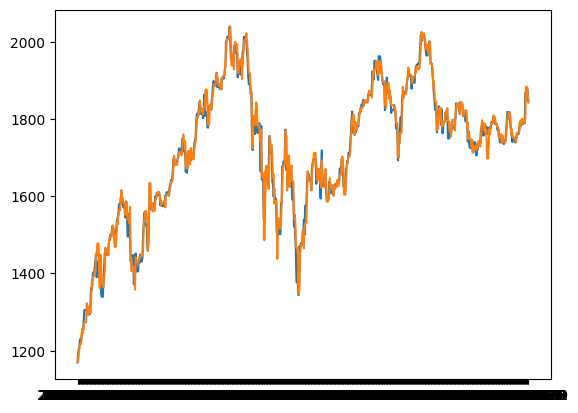

In [368]:
x_val = stocks['close_value']

y_val = stocks['day_date']
plt.plot(y_val, x_val)
plt.plot(stocks['open_value'])

In [369]:
features = ['sentiment']
# features = 'sentiment'
target = 'close_value'

In [370]:
print(stocks[features])
print(stocks[target])

     sentiment
0     0.522059
1     0.428862
2     0.335366
3     0.397436
4     0.395387
..         ...
725   0.407563
726   0.411765
727   0.447368
728   0.424474
729   0.386076

[730 rows x 1 columns]
0      1169.47
1      1189.01
2      1204.20
3      1209.59
4      1229.14
        ...   
725    1869.80
726    1869.80
727    1869.80
728    1846.89
729    1847.84
Name: close_value, Length: 730, dtype: float64


In [371]:
X_train, X_test, y_train, y_test = train_test_split(stocks[features], stocks[target], test_size=0.3, random_state=0)

In [372]:
print((y_test))

196    1822.49
187    1710.63
14     1305.20
31     1390.00
390    1670.57
        ...   
155    1696.35
391    1670.57
571    1943.05
306    1665.53
200    1813.70
Name: close_value, Length: 219, dtype: float64


In [374]:
model = LinearRegression()
model.fit(X_train,y_train)
model.score(X_test,y_test)


-0.013823979360100047

In [141]:
from sklearn.svm import SVC
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

ValueError: Unknown label type: 'continuous'

In [122]:

lr = LogisticRegression(solver='liblinear',multi_class='ovr')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

ValueError: Unknown label type: 'continuous'

ValueError: x and y must be the same size

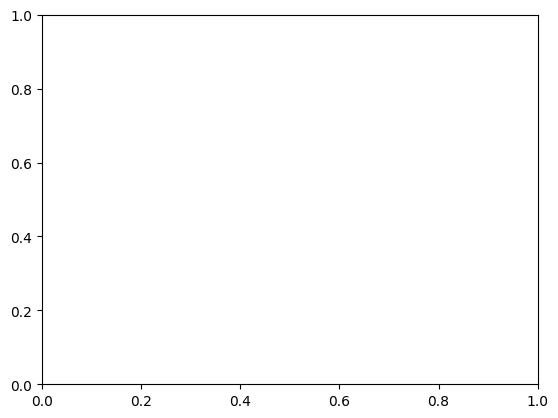

In [80]:
y_pred = model.predict(X_test)
plt.scatter(X_test, y_test, color ='b')
# plt.plot(X_test, y_pred, color ='k')
  
plt.show()

In [84]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
  
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
#squared True returns MSE value, False returns RMSE value.
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) #default=True
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)
  
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 21.79344910031526
MSE: 802.2318019422578
RMSE: 28.32369682690199


In [87]:
print(model.intercept_)

8.340584231695175


In [88]:
print(model.coef_)

[ 0.97883752 52.95296953]


In [86]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_true, y_pred)

NameError: name 'y_true' is not defined

In [89]:
import seaborn as sns # Convention alias for Seaborn



for var in features:
    plt.figure() # Creating a rectangle (figure) for each plot
    # Regression Plot also by default includes
    # best-fitting regression line
    # which can be turned off via `fit_reg=False`
    sns.regplot(x=var, y='close_value', data=df).set(title=f'Regression plot of {var} and Petrol Consumption');

KeyError: 'open_value'

<Figure size 640x480 with 0 Axes>

/var/folders/f0/zf6fxcgs5t778nd1ml7j0xlr0000gn/T/ipykernel_1361/4035882917.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = stocks.corr()


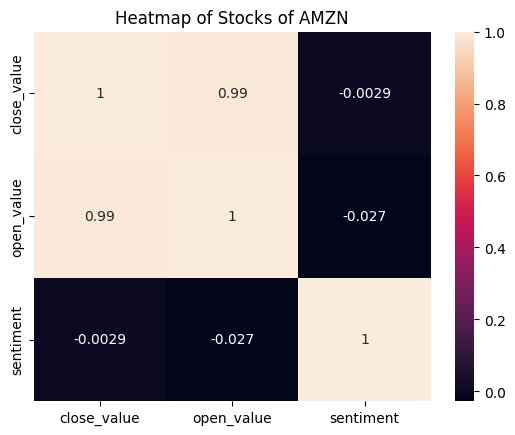

In [90]:
correlations = stocks.corr()
# annot=True displays the correlation values
sns.heatmap(correlations, annot=True).set(title='Heatmap of Stocks of AMZN');

In [111]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
from numpy import sqrt
from numpy import std

In [114]:
print(stocks['open_value'])

0      1182.35
1      1172.00
2      1188.30
3      1205.00
4      1217.51
        ...   
361    1473.35
362    1473.35
363    1473.35
364    1510.80
365    1510.80
Name: open_value, Length: 366, dtype: float64


In [119]:
X = stocks[['open_value']]
Y = stocks['close_value']
cv = KFold(n_splits=10, random_state=1, shuffle=True)
models = LinearRegression()
scores = cross_val_score(models, X, Y, scoring='neg_mean_absolute_error',cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


Accuracy: -22.601 (3.641)
